Exemple de visibilité du dataset GLEAM

/home/orenaud/Documents/GITHUB/VIS/vis-generator/dataflow_simulator
Min u : -30231.426923, Max u : 17860.497452
Min v : -22804.830289, Max v : 27478.047105
Min réel : -10.4285581666273, Max réel : 12.0908793522638
Min imaginaire : -11.6353456899264, Max imaginaire : 10.5571324792557
Maximum d'amplitude : 13.367794202018839


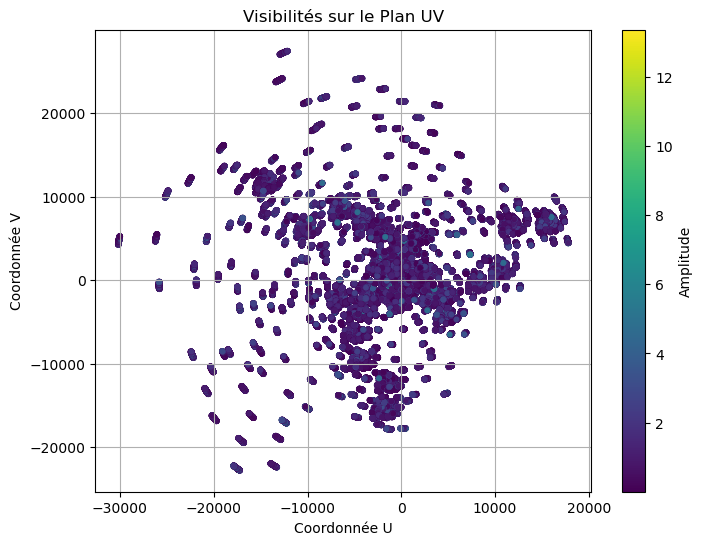

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os


current_directory = os.getcwd()
print(current_directory)

if not current_directory.endswith("vis-generator"):
    os.chdir("..")

# Charger les données depuis le fichier CSV
visibility_data = np.genfromtxt("example/GLEAM_small_visibilities_corrupted.csv", delimiter=' ', skip_header=1)

# Extraire les coordonnées u et v (ici j'utilise des colonnes fictives pour u et v, adaptez selon votre structure)
u_coord = visibility_data[:, 0]  # Première colonne : coordonnées u
v_coord = visibility_data[:, 1]  # Deuxième colonne : coordonnées v

print(f"Min u : {np.min(u_coord)}, Max u : {np.max(u_coord)}")
print(f"Min v : {np.min(v_coord)}, Max v : {np.max(v_coord)}")


# Extraire les parties réelle et imaginaire des visibilités
real_part = visibility_data[:, 3]  # 4e colonne : partie réelle
imag_part = visibility_data[:, 4]  # 5e colonne : partie imaginaire

print(f"Min réel : {np.min(real_part)}, Max réel : {np.max(real_part)}")
print(f"Min imaginaire : {np.min(imag_part)}, Max imaginaire : {np.max(imag_part)}")

# Calculer l'amplitude
amplitude = np.sqrt(real_part**2 + imag_part**2)

# **Afficher le maximum d'amplitude**
max_amplitude = np.max(amplitude)
print(f"Maximum d'amplitude : {max_amplitude}")

#print(visibility_data[:5])
#print(u_coord.dtype, v_coord.dtype)




# Tracer les visibilités sur le plan UV
plt.figure(figsize=(8, 6))
plt.scatter(u_coord, v_coord, c=amplitude, cmap='viridis', s=10)  # Taille et couleur selon l'amplitude
plt.colorbar(label='Amplitude')  # Ajouter une barre de couleurs pour l'amplitude
plt.title("Visibilités sur le Plan UV")
plt.xlabel("Coordonnée U")
plt.ylabel("Coordonnée V")
plt.grid(True)
plt.show()
os.chdir("dataflow_simulator/code")


#### Step 1: run the custom script to generate a .fits

Taille de la grille : 512
Nombre de sources : 3
Taille d'un pixel (en degrés) : 1.953125
Fichier FITS généré : radioastro.fits


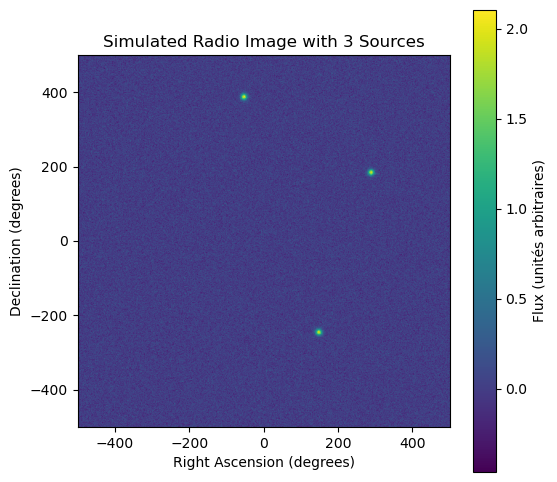

In [10]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

def generate_fits(size, num_sources, cell_size, output_file='radioastro.fits'):
    # Crée une grille avec un bruit de fond gaussien
    data = np.random.normal(loc=0.0, scale=0.1, size=(size, size))

    # Paramètres de la source
    source_amplitude = 2.0   # Intensité de la source
    source_sigma = 3.0       # Largeur de la gaussienne (en pixels)

    # Génère des sources aléatoires
    for _ in range(num_sources):
        x = np.random.randint(0, size)
        y = np.random.randint(0, size)
        
        # Crée une source gaussienne
        for i in range(size):
            for j in range(size):
                data[i, j] += source_amplitude * np.exp(-((i - x)**2 + (j - y)**2) / (2 * source_sigma**2))

    # Crée le fichier FITS avec les métadonnées
    hdu = fits.PrimaryHDU(data)

    # Met à jour l'en-tête avec les infos physiques
    hdu.header['CDELT1'] = -cell_size / np.sqrt(2)  # Taille du pixel en degrés (axe x)
    hdu.header['CDELT2'] = cell_size / np.sqrt(2)   # Taille du pixel en degrés (axe y)
    hdu.header['CRPIX1'] = size / 2    # Pixel de référence (centre)
    hdu.header['CRPIX2'] = size / 2
    hdu.header['CRVAL1'] = 0.0         # Coordonnée centrale en degrés
    hdu.header['CRVAL2'] = 0.0
    hdu.header['CTYPE1'] = 'RA---SIN'  # Type de projection
    hdu.header['CTYPE2'] = 'DEC--SIN'

    hdul = fits.HDUList([hdu])
    
    # Sauvegarde le fichier FITS
    hdul.writeto(output_file, overwrite=True)
    print(f"Fichier FITS généré : {output_file}")

    # Affiche l'image
    plt.figure(figsize=(6, 6))
    plt.imshow(data, cmap='viridis', origin='lower',
               extent=[-size * cell_size / 2, size * cell_size / 2,
                       -size * cell_size / 2, size * cell_size / 2])
    plt.colorbar(label='Flux (unités arbitraires)')
    plt.title(f'Simulated Radio Image with {num_sources} Sources')
    plt.xlabel('Right Ascension (degrees)')
    plt.ylabel('Declination (degrees)')
    plt.show()

if __name__ == "__main__":
    taille = int(input("Taille de la grille : ")) # ex: 512
    nb_sources = int(input("Nombre de sources : ")) # ex: 3
    cell_size = float(input("Taille d'un pixel (en degrés) : ")) # ex: 512
    generate_fits(taille, nb_sources, cell_size)


#### Step 1 convert fits to csv

In [12]:
import numpy
import sys
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np

def write_nparr_to_csv(data, filename, delimiter):
    # Ajout d'une colonne vide à droite
    #empty_column = numpy.full((data.shape[0], 1), numpy.nan)  # Colonne remplie de NaN
    #data = numpy.hstack((data, empty_column))

    # Écriture dans le fichier CSV/TSV
    numpy.savetxt(filename, data, delimiter=delimiter, fmt='%s')
    
    # Affichage des dimensions du tableau avant l'écriture
    print(f"Dimensions du tableau avant écriture : {data.shape}")

# Lecture du fichier FITS
#gt_name = "cycle_0_deconvolved.fits" #(dim = 2458, 2459)
#gt_name = "SGRA_full_gt.fits"
gt_name = "radioastro.fits"
hdul = fits.open(gt_name)  # Ouvre le fichier FITS
hdul.info()

#print(gt_hdu.header)  # Pour voir les métadonnées du fichier FITS


# Accéder au premier HDU (Primary HDU), y'en a qu'un de toute façon
gt_hdu = hdul[0]

# Extraire les informations d'en-tête
header = gt_hdu.header

# Extraire les valeurs de CDELT1 et CDELT2
celldelt1 = header.get('CDELT1')  # Taille du pixel en X (en degrés)
celldelt2 = header.get('CDELT2')  # Taille du pixel en Y (en degrés)

CELL_SIZE = (celldelt1**2 + celldelt2**2)**0.5  # Hypothèse : le cell_size est la norme du vecteur (CDELT1, CDELT2)
print(f"Taille du pixel (cell_size) : {CELL_SIZE} degrés")


data = gt_hdu.data
#print(data)
#print(data.shape)
#print(type(data))






data = gt_hdu.data
print(data.ndim)
# Si le tableau a plus de 2 dimensions, sélectionne la première tranche
if data.ndim > 2:
    data = data[0, 0, :, :]

# Réinversion du tableau (inversion des axes)
result = numpy.flip(data)

# Affichage des dimensions du tableau avant de l'écrire
print(f"Dimensions du tableau à écrire : {result.shape}")

# Écriture dans le fichier CSV/TSV
IMAGE = "image.csv"
write_nparr_to_csv(result, IMAGE, ",")
print("Fichier sauvegarder dans : "+IMAGE)


Filename: radioastro.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   (512, 512)   float64   
Taille du pixel (cell_size) : 1.9531249999999998 degrés
2
Dimensions du tableau à écrire : (512, 512)
Dimensions du tableau avant écriture : (512, 512)
Fichier sauvegarder dans : image.csv


#### Step 2 build degridding kernels

Dans les pipelines classique d'imagerie radio-interferometrique les kernels (ou noyaux) sont utilisé pour les convolutions sur les données. Les noyaux de gidding degridding sont des fonctions qui prennent en compte l'espacement des points de données et leur position relative sur la grille, et elles ajustent les valeurs des pixels de l'image pour correspondre aux signaux capturés par les antennes.

Ici, les noyaux sont utilisés pour simuler l'impact du réseau d'antennes sur l'image de sortie, en tenant compte de plusieurs facteurs comme :

1.    Projection spatiale : Le réseau interférométrique capte des signaux provenant de différentes positions dans l’espace. Les kernels sont utilisés pour projeter l'information contenue dans l'image (domaine spatial) sur les visibilités, en tenant compte des fréquences et des angles de vue des antennes.

2.    Transformation de Fourier : Les visibilités sont souvent obtenues par une transformation de Fourier des données, ce qui permet de passer du domaine spatial au domaine fréquentiel. Les kernels utilisés dans cette transformation permettent de modéliser comment les différentes fréquences (composantes de l'onde radio) sont captées par les antennes. Ces transformations sont souvent réalisées via des kernels de gridding, qui placent les données mesurées sur une grille régulière avant de les convertir en visibilités.

3.    Correction des distorsions : Les distorsions peuvent apparaître lors de la conversion des données spatiales vers les données fréquentielles. Les kernels sphéroïdaux ou d'autres types de filtres peuvent être utilisés pour éviter des artefacts comme le repliement des fréquences (aliasing) et garantir que les visibilités simulées sont réalistes.

Kernels et supports sauvegardés dans les fichiers CSV avec facteur de suréchantillonnage 16


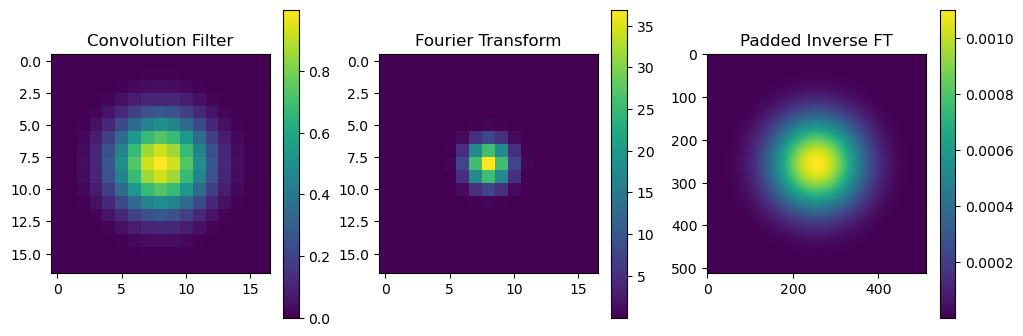

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Vitesse de la lumière en m/s
lightspeed = 299792458.

# Fonction qui génère les coefficients pour le polynôme 2D (x^i * y^j)
def _gen_coeffs(x, y, order):
    ncols = (order + 1) ** 2  # Nombre total de coefficients (ordre+1)^2
    coeffs = np.empty((x.size, ncols), dtype=x.dtype)
    c = 0
    # Remplissage des coefficients pour chaque monome x^i * y^j
    for i in range(order + 1):
        for j in range(order + 1):
            coeffs[:, c] = x**i * y**j  # Calcul du monome pour chaque combinaison (i, j)
            c += 1
    return coeffs

# Fonction qui effectue un ajustement polynomial 2D par moindres carrés
def polyfit2d(x, y, z, order=3):
    # Utilise les coefficients générés par _gen_coeffs pour résoudre le système
    return np.linalg.lstsq(_gen_coeffs(x, y, order), z, rcond=None)[0]

# Fonction qui évalue un polynôme 2D avec les coefficients donnés
def polyval2d(x, y, coeffs):
    order = int(np.sqrt(coeffs.size)) - 1  # Calcul de l'ordre à partir du nombre de coefficients
    z = np.zeros_like(x)  # Initialisation de la sortie (z)
    c = 0
    # Calcul de la valeur du polynôme pour chaque (x, y)
    for i in range(order + 1):
        for j in range(order + 1):
            z += coeffs[c] * x**i * y**j  # Addition de chaque terme du polynôme
            c += 1
    return z

# Matrices P et Q utilisées dans le calcul de la fonction sphéroïdale
P = np.array([
    [8.203343e-2, -3.644705e-1, 6.278660e-1, -5.335581e-1, 2.312756e-1],
    [4.028559e-3, -3.697768e-2, 1.021332e-1, -1.201436e-1, 6.412774e-2]])

Q = np.array([
    [1.0000000e0, 8.212018e-1, 2.078043e-1],
    [1.0000000e0, 9.599102e-1, 2.918724e-1]])

# Fonction qui génère le filtre sphéroïdal 2D
def spheroidal_2d(npix, factor=1.0):
    result = np.zeros((npix, npix), dtype=np.float32)  # Initialisation de la matrice de résultats
    c = np.linspace(-1.0, 1.0, npix)  # Création des coordonnées normalisées
    for y, yc in enumerate(c):
        y_sqrd = yc ** 2  # Carré de y
        for x, xc in enumerate(c):
            r = np.sqrt(xc**2 + y_sqrd) * factor  # Calcul de la distance radiale normalisée
            if r < 0.75:
                poly = 0
                end = 0.75
            elif r <= 1.00:
                poly = 1
                end = 1.00
            else:
                continue  # Si la distance est trop grande, on passe à la prochaine valeur

            sP = P[poly]  # Sélectionne les coefficients appropriés dans P
            sQ = Q[poly]  # Sélectionne les coefficients appropriés dans Q
            nu_sqrd = r**2  # Calcul du carré de la distance radiale
            del_nu_sqrd = nu_sqrd - end**2  # Calcul de la différence par rapport à la borne

            top = sP[0] + sum(sP[i] * del_nu_sqrd**i for i in range(1, 5))  # Calcul du numérateur
            bot = sQ[0] + sum(sQ[i] * del_nu_sqrd**i for i in range(1, 3))  # Calcul du dénominateur

            result[y, x] = (1.0 - nu_sqrd) * (top / bot)  # Calcul final de la valeur du filtre sphéroïdal
    return result

# Fonction pour ajouter du padding à une image (centrée et avec des zéros)
def zero_pad(img, npix):
    # Calcul des dimensions du padding pour centrer l'image
    padding = [(int((npix - s) // 2), int((npix - s + 1) // 2)) for s in img.shape]
    return np.pad(img, padding, mode='constant', constant_values=0)

# Fonction pour générer et appliquer un filtre sphéroïdal anti-aliasing
def spheroidal_aa_filter(npix, support=11, spheroidal_support=111):
    # Génère un filtre sphéroïdal 2D
    cf = spheroidal_2d(spheroidal_support).astype(np.complex128)
    # Applique la transformée de Fourier
    fcf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(cf)))
    
    xc = spheroidal_support // 2
    # Sélectionne un sous-ensemble du filtre
    start = xc - support // 2
    end = 1 + xc + support // 2
    fcf = fcf[start:end, start:end].copy()

    # Effectue un padding sur la transformée de Fourier pour l'adapter à npix
    zfcf = zero_pad(fcf, int(npix))
    # Applique l'inverse de la transformée de Fourier
    ifzfcf = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(zfcf)))
    
    return cf, fcf, ifzfcf

# Fonction qui exporte les kernels et supports dans des fichiers CSV
def write_kernels_to_csv(gridding_kernels, degridding_kernels, supports_g, supports_dg, filename, oversampling_factor):
    # Création des noms de fichiers pour les kernels et supports
    dk_filename_r = filename + "_degridding_kernels_real_x" + str(oversampling_factor) + ".csv"
    dk_filename_i = filename + "_degridding_kernels_imag_x" + str(oversampling_factor) + ".csv"
    gk_filename_r = filename + "_gridding_kernels_real_x" + str(oversampling_factor) + ".csv"
    gk_filename_i = filename + "_gridding_kernels_imag_x" + str(oversampling_factor) + ".csv"
    ds_filename = filename + "_degridding_kernel_supports_x" + str(oversampling_factor) + ".csv"
    gs_filename = filename + "_gridding_kernel_supports_x" + str(oversampling_factor) + ".csv"

    # Exportation des parties réelles et imaginaires des kernels dans des fichiers CSV
    np.savetxt(dk_filename_r, degridding_kernels.real, delimiter=',')
    np.savetxt(dk_filename_i, degridding_kernels.imag, delimiter=',')
    np.savetxt(gk_filename_r, gridding_kernels.real, delimiter=',')
    np.savetxt(gk_filename_i, gridding_kernels.imag, delimiter=',')

    # Exportation des supports dans des fichiers CSV
    np.savetxt(ds_filename, supports_dg, delimiter=',')
    np.savetxt(gs_filename, supports_g, delimiter=',')

    print(f"Kernels et supports sauvegardés dans les fichiers CSV avec facteur de suréchantillonnage {oversampling_factor}")

# ======== TEST ==========
GRID_SIZE = 512  # Nombre de pixels pour le calcul
NUM_DEGRIDDING_KERNELS = 17  # Taille du support du kernel

# Génération du filtre sphéroïdal et de ses variantes dans l'espace de Fourier
cf, fcf, ifzfcf = spheroidal_aa_filter(GRID_SIZE, NUM_DEGRIDDING_KERNELS, NUM_DEGRIDDING_KERNELS)

# Création de kernels de test (aléatoires)
gridding_kernels = np.random.random((NUM_DEGRIDDING_KERNELS, NUM_DEGRIDDING_KERNELS))  # Exemple de kernel de gridding
degridding_kernels = np.random.random((NUM_DEGRIDDING_KERNELS, NUM_DEGRIDDING_KERNELS))  # Exemple de kernel de degridding
supports_g = np.array([NUM_DEGRIDDING_KERNELS])  # Support pour les kernels de gridding
supports_dg = np.array([NUM_DEGRIDDING_KERNELS])  # Support pour les kernels de degridding

# Nom du fichier pour l'exportation
filename = "config/wproj_manualconj"
OVERSAMPLING_FACTOR = 16  # Facteur de suréchantillonnage

# Exportation des kernels et supports en CSV
write_kernels_to_csv(gridding_kernels, degridding_kernels, supports_g, supports_dg, filename, OVERSAMPLING_FACTOR)

# Visualisation des résultats (filtre, transformée de Fourier, et inverse FFT)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Convolution Filter')
plt.imshow(cf.real)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title('Fourier Transform')
plt.imshow(np.abs(fcf))
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title('Padded Inverse FT')
plt.imshow(np.abs(ifzfcf))
plt.colorbar()

plt.show()

# merci chatgpt

#### Step3 run the dataflow executable

In [14]:
import os
import subprocess

# Chemin vers le dossier dataflow
dataflow_directory = "code"

# Vérifie si on est déjà dans le bon dossier
current_directory = os.getcwd()
if not current_directory.endswith(dataflow_directory):
    print(f"Le répertoire actuel est {current_directory}. Changement vers {dataflow_directory}...")
    os.chdir(dataflow_directory)
else:
    print(f"On est déjà dans le répertoire {dataflow_directory}.")

EXECUTABLE = "./STD_DEGRID"

print(f"Lancement : {EXECUTABLE}")
result = subprocess.run(EXECUTABLE, capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print(f"Erreur :\n{result.stderr}")
    
os.chdir("..")
print(os.getcwd())

On est déjà dans le répertoire code.
Lancement : ./STD_DEGRID
UPDATE >>> Image loaded from image.csv
Grille d'entrée 0: 0.004085 + 0.000000i
Grille d'entrée 1: 0.000000 + 0.000000i
Grille d'entrée 2: 0.000000 + 0.000000i
Grille d'entrée 3: 0.000000 + 0.000000i
Grille d'entrée 4: 0.000000 + 0.000000i
Grille d'entrée 5: 0.000000 + 0.000000i
Grille d'entrée 6: 0.000000 + 0.000000i
Grille d'entrée 7: 0.000000 + 0.000000i
Grille d'entrée 8: 0.000000 + 0.000000i
Grille d'entrée 9: 0.000000 + 0.000000i
UPDATE >>> Loading degridding kernel support file from config/wproj_manualconj_degridding_kernel_supports_x16.csv...

UPDATE >>> Total number of samples needed to store degridding kernels is -2147483648...

UPDATE >>> Loading kernel files file from config/wproj_manualconj_degridding_kernels_real_x16.csv real and config/wproj_manualconj_degridding_kernels_imag_x16.csv imaginary...

Degridding visibilities using FFT degridder
i: 0, grid_pos: (0.000000, -0.000000)
i: 1, grid_pos: (-0.000000, 0.000

step 3 convertir les 2 fichier en .fits

2


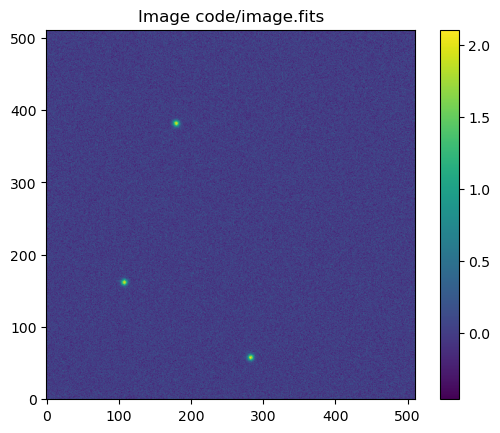

In [17]:
import numpy
import sys
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt

def write_nparr_to_fits(data, filename):
    hdu = fits.PrimaryHDU(data)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(filename, overwrite=True)
    hdulist.close()

def display_fits_image(fits_file):
    # Charger les données du fichier FITS
    hdulist = fits.open(fits_file)
    data = hdulist[0].data  # Les données de l'image sont dans la première extension
    print(data.ndim)
    hdulist.close()

    # Affichage de l'image avec matplotlib
    plt.imshow(data, cmap='viridis', origin='lower')
    plt.colorbar()  # Ajoute une barre de couleur pour l'échelle des intensités
    plt.title(f"Image {fits_file}")
    plt.show()

IMAGE = "code/image.csv"
FITS = "code/image.fits"
delimiter = ","

result = numpy.genfromtxt(IMAGE, delimiter=delimiter)[:,:-1]  # Ignorer la dernière colonne si nécessaireresult = numpy.flip(result)

write_nparr_to_fits(result, FITS)
display_fits_image(FITS)

Min u : -0.999222, Max u : 0.942073
Min v : -0.995747, Max v : 0.985598
Min réel : 0.0, Max réel : 0.0
Min imaginaire : 0.0, Max imaginaire : 0.0
Maximum d'amplitude : 0.0


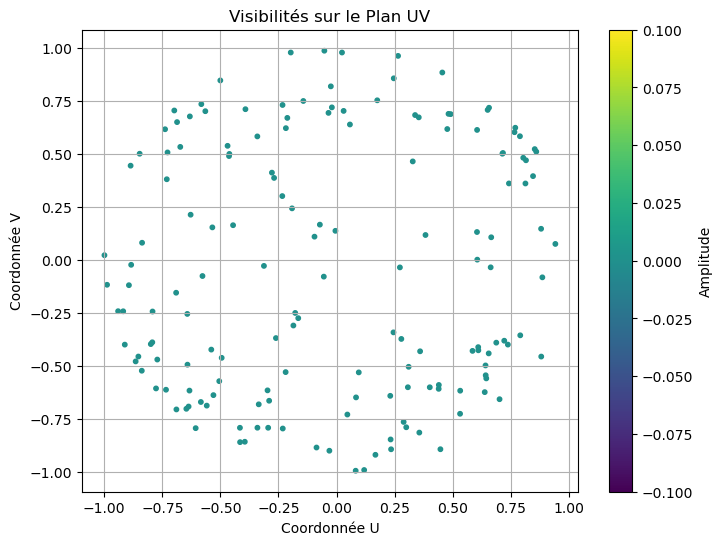

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Charger les données depuis le fichier CSV
visibility_data = np.genfromtxt("code/vis.csv", delimiter=' ', skip_header=1)


visibility_data = visibility_data[~np.isnan(visibility_data).any(axis=1)]
#visibility_data = np.array(visibility_data, dtype=np.float32)

# Extraire les coordonnées u et v (ici j'utilise des colonnes fictives pour u et v, adaptez selon votre structure)
u_coord = visibility_data[:, 0]  # Première colonne : coordonnées u
v_coord = visibility_data[:, 1]  # Deuxième colonne : coordonnées v

print(f"Min u : {np.min(u_coord)}, Max u : {np.max(u_coord)}")
print(f"Min v : {np.min(v_coord)}, Max v : {np.max(v_coord)}")


# Extraire les parties réelle et imaginaire des visibilités
real_part = visibility_data[:, 3]  # 4e colonne : partie réelle
imag_part = visibility_data[:, 4]  # 5e colonne : partie imaginaire

print(f"Min réel : {np.min(real_part)}, Max réel : {np.max(real_part)}")
print(f"Min imaginaire : {np.min(imag_part)}, Max imaginaire : {np.max(imag_part)}")

# Calculer l'amplitude
amplitude = np.sqrt(real_part**2 + imag_part**2)

# **Afficher le maximum d'amplitude**
max_amplitude = np.max(amplitude)
print(f"Maximum d'amplitude : {max_amplitude}")

#print(visibility_data[:5])
#print(u_coord.dtype, v_coord.dtype)




# Tracer les visibilités sur le plan UV
plt.figure(figsize=(8, 6))
plt.scatter(u_coord, v_coord, c=amplitude, cmap='viridis', s=10)  # Taille et couleur selon l'amplitude
plt.colorbar(label='Amplitude')  # Ajouter une barre de couleurs pour l'amplitude
plt.title("Visibilités sur le Plan UV")
plt.xlabel("Coordonnée U")
plt.ylabel("Coordonnée V")
plt.grid(True)
plt.show()
